# Notebook for CCI-derived metabolism from scRNA-Seq using MEBOCOST in Fetal Stem Cells and Neuronal cells
- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 20th November 2023

### Import packages

In [1]:
import os,sys
import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from mebocost import mebocost

### Set up the cells

In [2]:
%matplotlib inline

In [3]:
sc.settings.verbosity = 3
sc.logging.print_versions()

sc.settings.set_figure_params(frameon=False, dpi=100)

The `sinfo` package has changed name and is now called `session_info` to become more discoverable and self-explanatory. The `sinfo` PyPI package will be kept around to avoid breaking old installs and you can downgrade to 0.3.2 if you want to use it without seeing this message. For the latest features and bug fixes, please install `session_info` instead. The usage and defaults also changed slightly, so please review the latest README at https://gitlab.com/joelostblom/session_info.
-----
anndata     0.9.2
scanpy      1.8.2
sinfo       0.3.4
-----
PIL                         10.1.0
adjustText                  NA
anyio                       NA
arrow                       1.3.0
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.13.1
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.1.0
certifi                     2023.07.22
cffi         

In [22]:
import warnings

warnings.simplefilter("ignore", category=UserWarning)

In [23]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

### Data Upload

In [42]:
input_path = '/home/amaguza/data/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_other_fetal_cells/FetalSC_and_neuronal_cells_raw.h5ad'
adata = sc.read_h5ad(input_path)

In [43]:
# Extract the raw counts
adata = adata.raw.to_adata()
adata

AnnData object with n_obs × n_vars = 24971 × 26442
    obs: 'Sample_ID', 'Cell Type', 'Study_name', 'Donor_ID', 'Diagnosis', 'Age', 'Region code', 'Fraction', 'Sex', 'Library_Preparation_Protocol', 'batch', 'Age_group', 'Location', 'Cell States', 'Cell States GCA', 'Chem', 'Layer', 'Cell States Kong', 'dataset', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'Cell_ID', '_scvi_batch', '_scvi_labels'
    var: 'feature_types-0-0-0', 'gene_name-1-0-0', 'gene_id-0-0', 'GENE-1-0'

In [44]:
X_is_raw(adata)

True

In [45]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after = 1e6)
sc.pp.log1p(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Infer metabolic communications

* The mebocost.conf file needs to be provided. It is in the original repo and after installation it will have the correct paths and should work out of the box. You could provide the full path to the file, or create a symlink.

In [46]:
mebo_obj = mebocost.create_obj(
                        adata = adata,
                        group_col = ['Cell States'],
                        met_est = 'mebocost',
                        config_path = '/home/amaguza/MEBOCOST/mebocost.conf',
                        exp_mat = None,
                        cell_ann = None,
                        species = 'human',
                        met_pred = None,
                        met_enzyme = None,
                        met_sensor = None,
                        met_ann = None,
                        scFEA_ann = None,
                        compass_met_ann = None,
                        compass_rxn_ann = None,
                        gene_network = None,
                        gmt_path = None,
                        cutoff_exp = 'auto', ## automated cutoff to exclude lowly ranked 25% sensors across all cells
                        cutoff_met = 'auto', ## automated cutoff to exclude lowly ranked 25% metabolites across all cells
                        cutoff_prop = 0.25, ## at lease 25% of cells should be expressed the sensor or present the metabolite in the cell group (specified by group_col)
                        sensor_type = ['Receptor', 'Transporter', 'Nuclear Receptor'],
                        thread = 4
                        )

[November 20, 2023 16:00:28]: We get expression data with 26442 genes and 24971 cells.
[November 20, 2023 16:00:28]: Data Preparation Done in 0.1116 seconds


### Estimate metabolite presence

* If you just want the table of metabolic activity, you can stop here and export it as a CSV file.

In [47]:
mebo_obj._load_config_()
mebo_obj.estimator()

[November 20, 2023 16:00:30]: Load config and read data based on given species [human].
[November 20, 2023 16:00:31]: Estimtate metabolite level using mebocost


In [48]:
met_mat = pd.DataFrame(mebo_obj.met_mat.toarray(),
                      index = mebo_obj.met_mat_indexer,
                      columns = mebo_obj.met_mat_columns)
met_mat.head()

AAACCTGCATCTACGA-1-Human_colon_16S8159182  \
HMDB0003450                                   0.000000   
HMDB0003948                                   1.755592   
HMDB0003712                                   1.404473   
HMDB0003945                                   2.055245   
HMDB0003949                                   1.755592   

             AAACCTGCATCTGGTA-1-Human_colon_16S8159182  \
HMDB0003450                                   0.000000   
HMDB0003948                                   0.000000   
HMDB0003712                                   0.000000   
HMDB0003945                                   0.674901   
HMDB0003949                                   0.000000   

             AAACGGGTCGGCGCAT-1-Human_colon_16S8159182  \
HMDB0003450                                   0.000000   
HMDB0003948                                   0.677888   
HMDB0003712                                   0.542310   
HMDB0003945                                   0.602567   
HMDB0003949                                   0.677888   

             AAACGGGTCTTACCGC-1-Human_colon_16S8159182  \
HMDB0003450                                   2.198213   
HMDB0003948                                   2.506251   
HMDB0003712                                   2.444643   
HMDB0003945                                   2.227778   
HMDB0003949                                   2.506251   

             AAAGATGAGATATACG-1-Human_colon_16S8159182  \
HMDB0003450                                   0.000000   
HMDB0003948                                   1.641982   
HMDB0003712                                   2.071628   
HMDB0003945                                   1.880674   
HMDB0003949                                   1.641982   

             AAAGATGGTCTCCATC-1-Human_colon_16S8159182  \
HMDB0003450                                   2.200197   
HMDB0003948                                   1.358103   
HMDB0003712                                   1.526522   
HMDB0003945                                   1.207203   
HMDB0003949                                   1.358103   

             AAAGATGTCACCTTAT-1-Human_colon_16S8159182  \
HMDB0003450                                   0.000000   
HMDB0003948                                   0.628615   
HMDB0003712                                   0.502892   
HMDB0003945                                   0.558769   
HMDB0003949                                   0.628615   

             AAAGCAACACCATCCT-1-Human_colon_16S8159182  \
HMDB0003450                                   0.000000   
HMDB0003948                                   0.913687   
HMDB0003712                                   0.730950   
HMDB0003945                                   0.812167   
HMDB0003949                                   0.913687   

             AAAGCAAGTGACCAAG-1-Human_colon_16S8159182  \
HMDB0003450                                   0.000000   
HMDB0003948                                   2.028632   
HMDB0003712                                   2.394315   
HMDB0003945                                   2.269467   
HMDB0003949                                   2.028632   

             AAAGCAAGTTAGATGA-1-Human_colon_16S8159182  ...  \
HMDB0003450                                   0.000000  ...   
HMDB0003948                                   0.702768  ...   
HMDB0003712                                   0.562215  ...   
HMDB0003945                                   0.624683  ...   
HMDB0003949                                   0.702768  ...   

             TTCTCCTGTGTCGCTG-1-4918STDY7718977  \
HMDB0003450                            0.000000   
HMDB0003948                            1.174293   
HMDB0003712                            0.939434   
HMDB0003945                            1.043816   
HMDB0003949                            1.174293   

             TTCTTAGCAGGGATTG-1-4918STDY7718977  \
HMDB0003450                            0.000000   
HMDB0003948                            1.187591   
HMDB0003712                      

### MEBOCOST cell-cell communication inference

In [49]:
commu_res = mebo_obj.infer_commu(
                                n_shuffle = 1000,
                                seed = 1712, 
                                Return = True, 
                                thread = 4,
                                save_permuation = False,
                                min_cell_number = 3
                            )

[November 20, 2023 16:01:32]: Load config and read data based on given species [human].
[November 20, 2023 16:01:34]: Estimtate metabolite level using mebocost
[November 20, 2023 16:01:43]: Infer communications
[November 20, 2023 16:01:43]: Sensor type used ['Transporter', 'Receptor', 'Nuclear Receptor']
[November 20, 2023 16:01:43]: Parameters: {shuffling: 1000 times, random seed: 1712, thread: 4}
[November 20, 2023 16:01:50]: met_sensor: (350, 8)
[November 20, 2023 16:01:50]: avg_exp: (2166, 18) for (gene, cell) of needed
[November 20, 2023 16:01:50]: avg_met: (592, 18) for (metabolite, cell) of needed
[November 20, 2023 16:01:50]: shuffling 1000 times for generating backgroud
[November 20, 2023 16:01:54]: take exp and met avg for shuffling
[November 20, 2023 16:02:09]: thread: 4
[November 20, 2023 16:02:10]: ABCA1 ~ HMDB0006247
[November 20, 2023 16:02:10]: Normalizing Cluster Mean and Calculating Communication Score
[November 20, 2023 16:02:10]: Calculating P-value
[November 20, 20

In [50]:
print('sensor_exp cutoff: %s'%mebo_obj.cutoff_exp)
print('metabolite_presence cutoff: %s'%mebo_obj.cutoff_met)

sensor_exp cutoff: 4.448960781097412
metabolite_presence cutoff: 0.7798052430152893


In [51]:
# Save results
commu_res.to_csv('/home/amaguza/data/Processed_data/Gut_data/Fetal_stem_cells/FetalSC_and_other_fetal_cells/FetalSC_and_neuronal_mebocost_results.csv')

### Visualise MEBOCOST prediction

### Showing the detailed communications (sender-receiver vs metabolite-sensor) in a dot map

In [52]:
adata.obs['Cell States'].value_counts()

ASS1+_SLC40A1+_SC       3979
RPS10+_RPS17+_SC        3544
ENCC/glia Progenitor    3234
cycling ENCC/glia       2923
Branch B1 (eMN)         1923
Branch A1 (iMN)         1712
Neuroblast              1650
Glia 3 (BCAN+)          1448
Glia 1 (DHH+)            956
cycling neuroblast       689
Branch A2 (IPAN/IN)      682
Glia 2 (ELN+)            552
Branch B2 (eMN)          501
Differentiating glia     459
FXYD3+_CKB+_SC           294
Branch A3 (IPAN/IN)      247
Branch A4 (IN)           127
Branch B3 (IPAN)          51
Name: Cell States, dtype: int64

[November 20, 2023 16:05:21]: plot heatmap for significant result


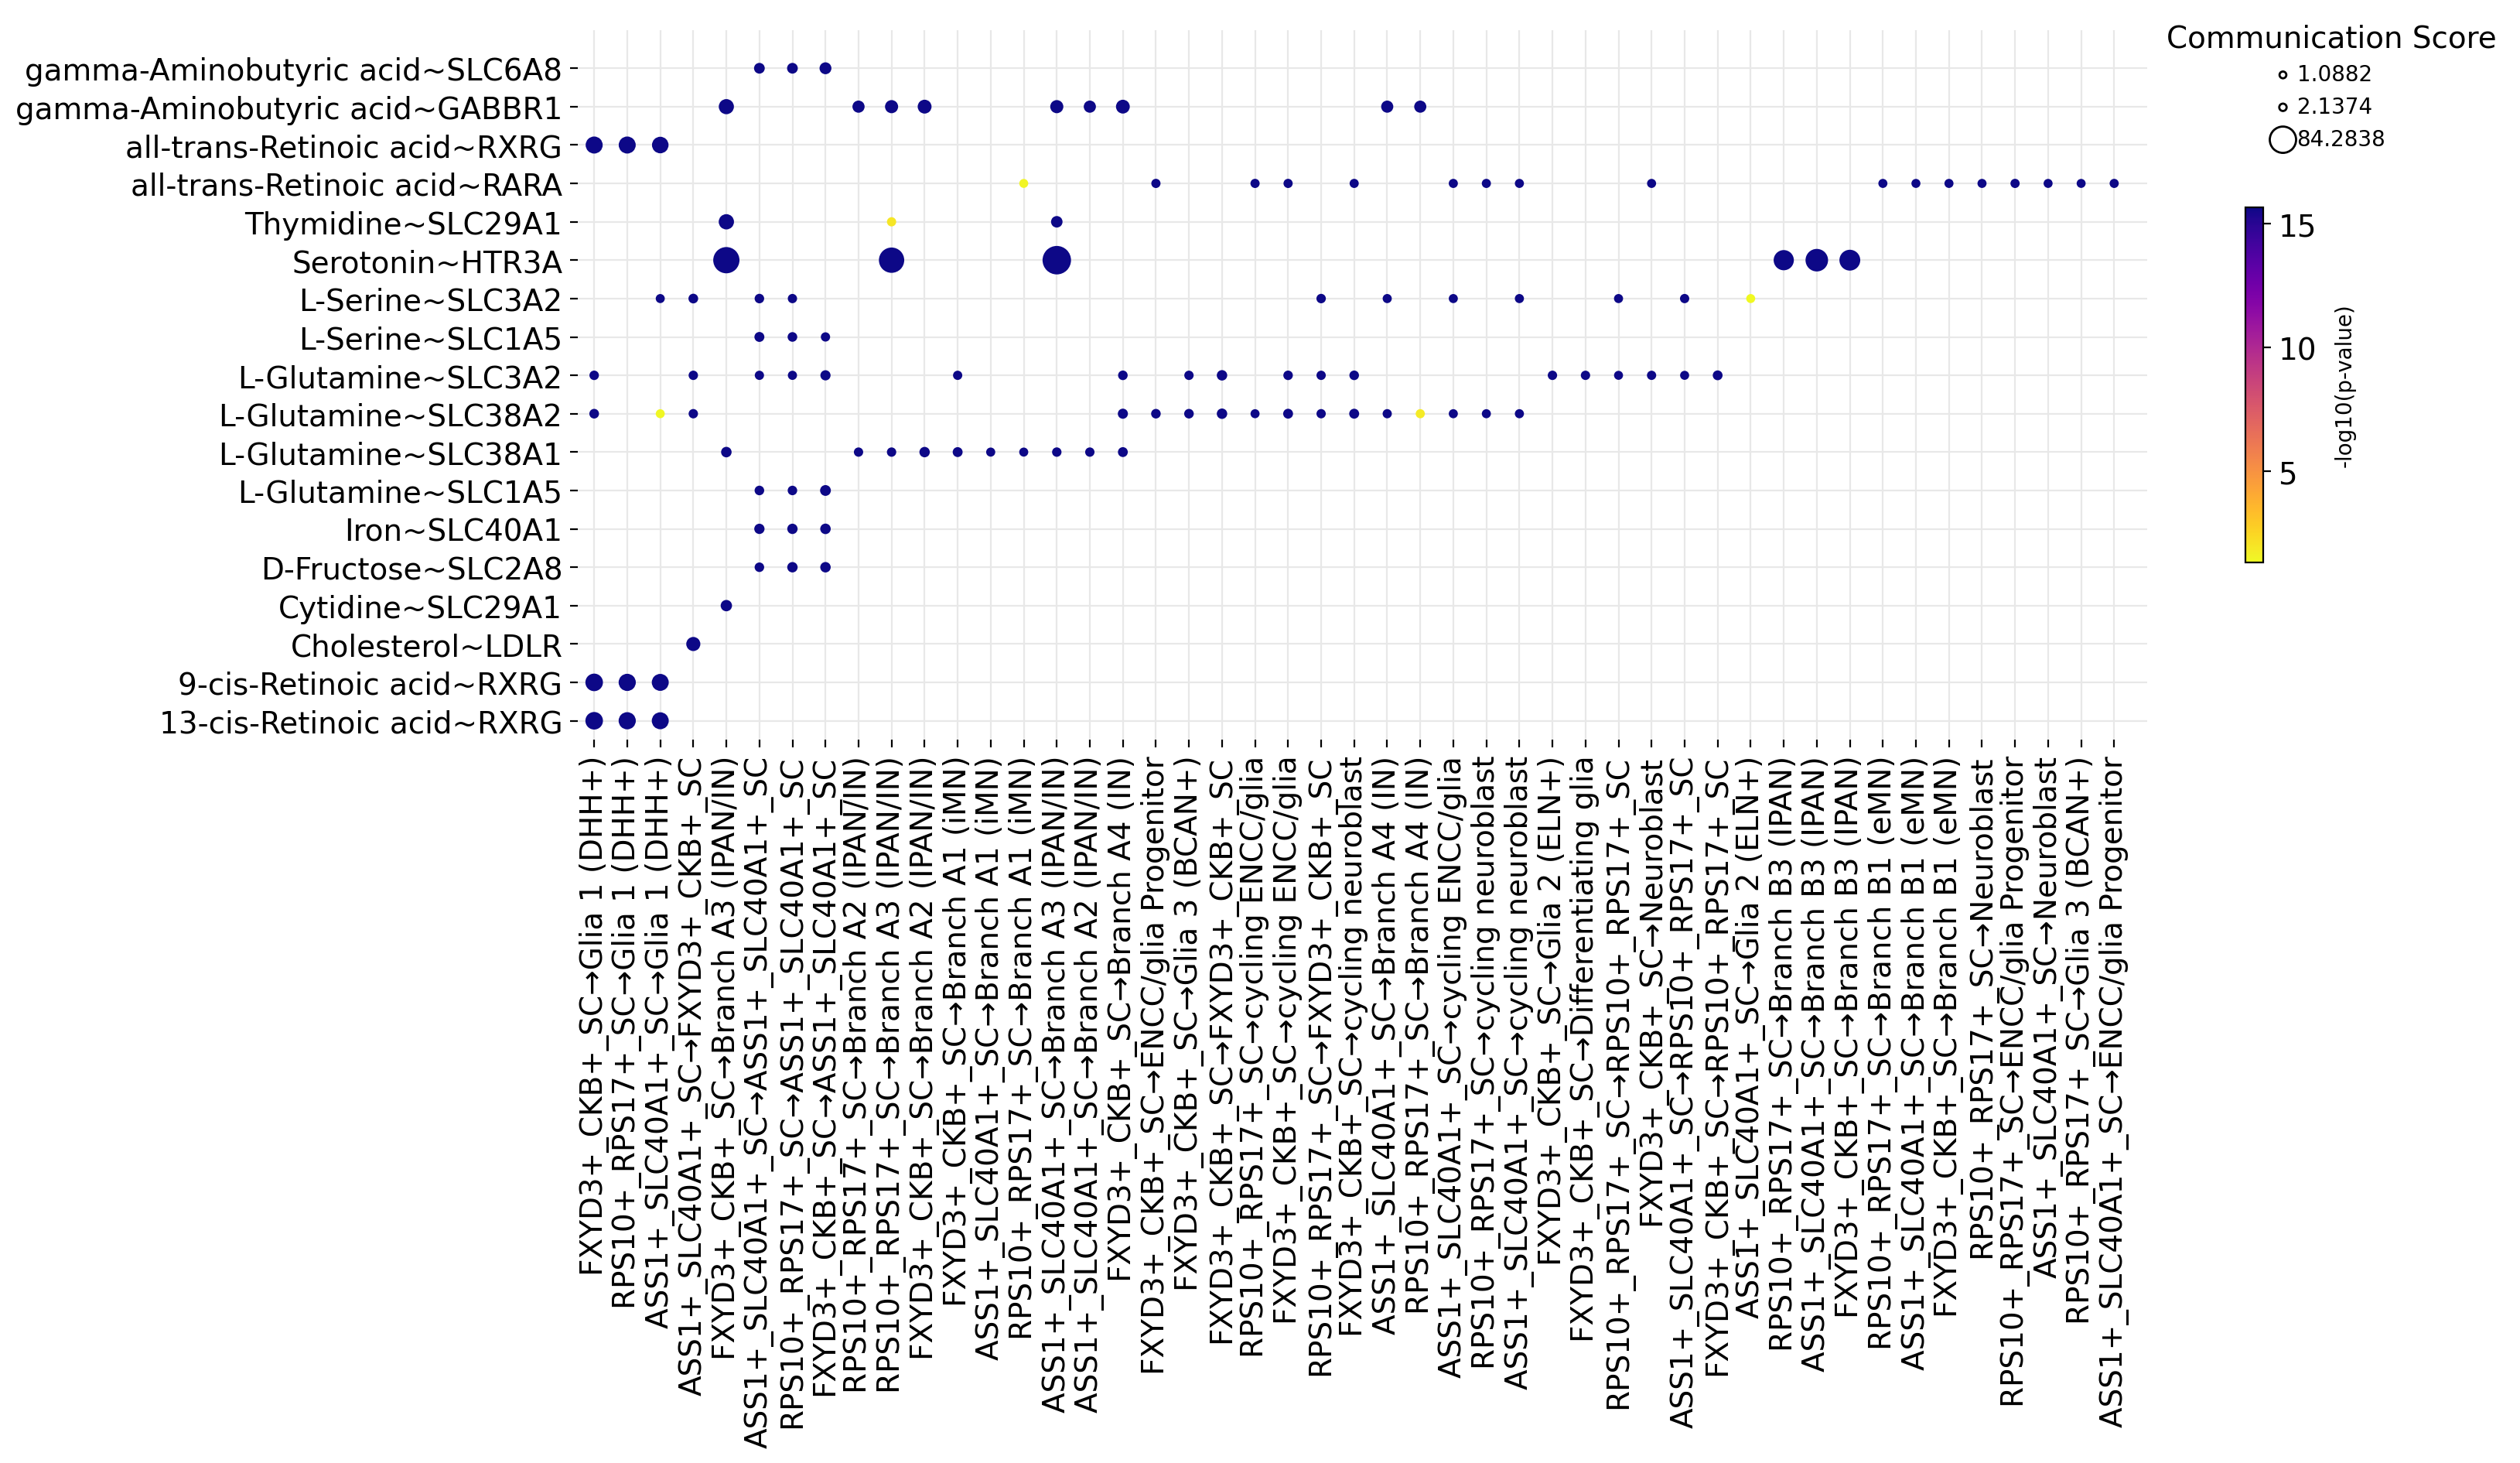

In [53]:
mebo_obj.commu_dotmap(
                sender_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

[November 20, 2023 16:05:22]: plot heatmap for significant result


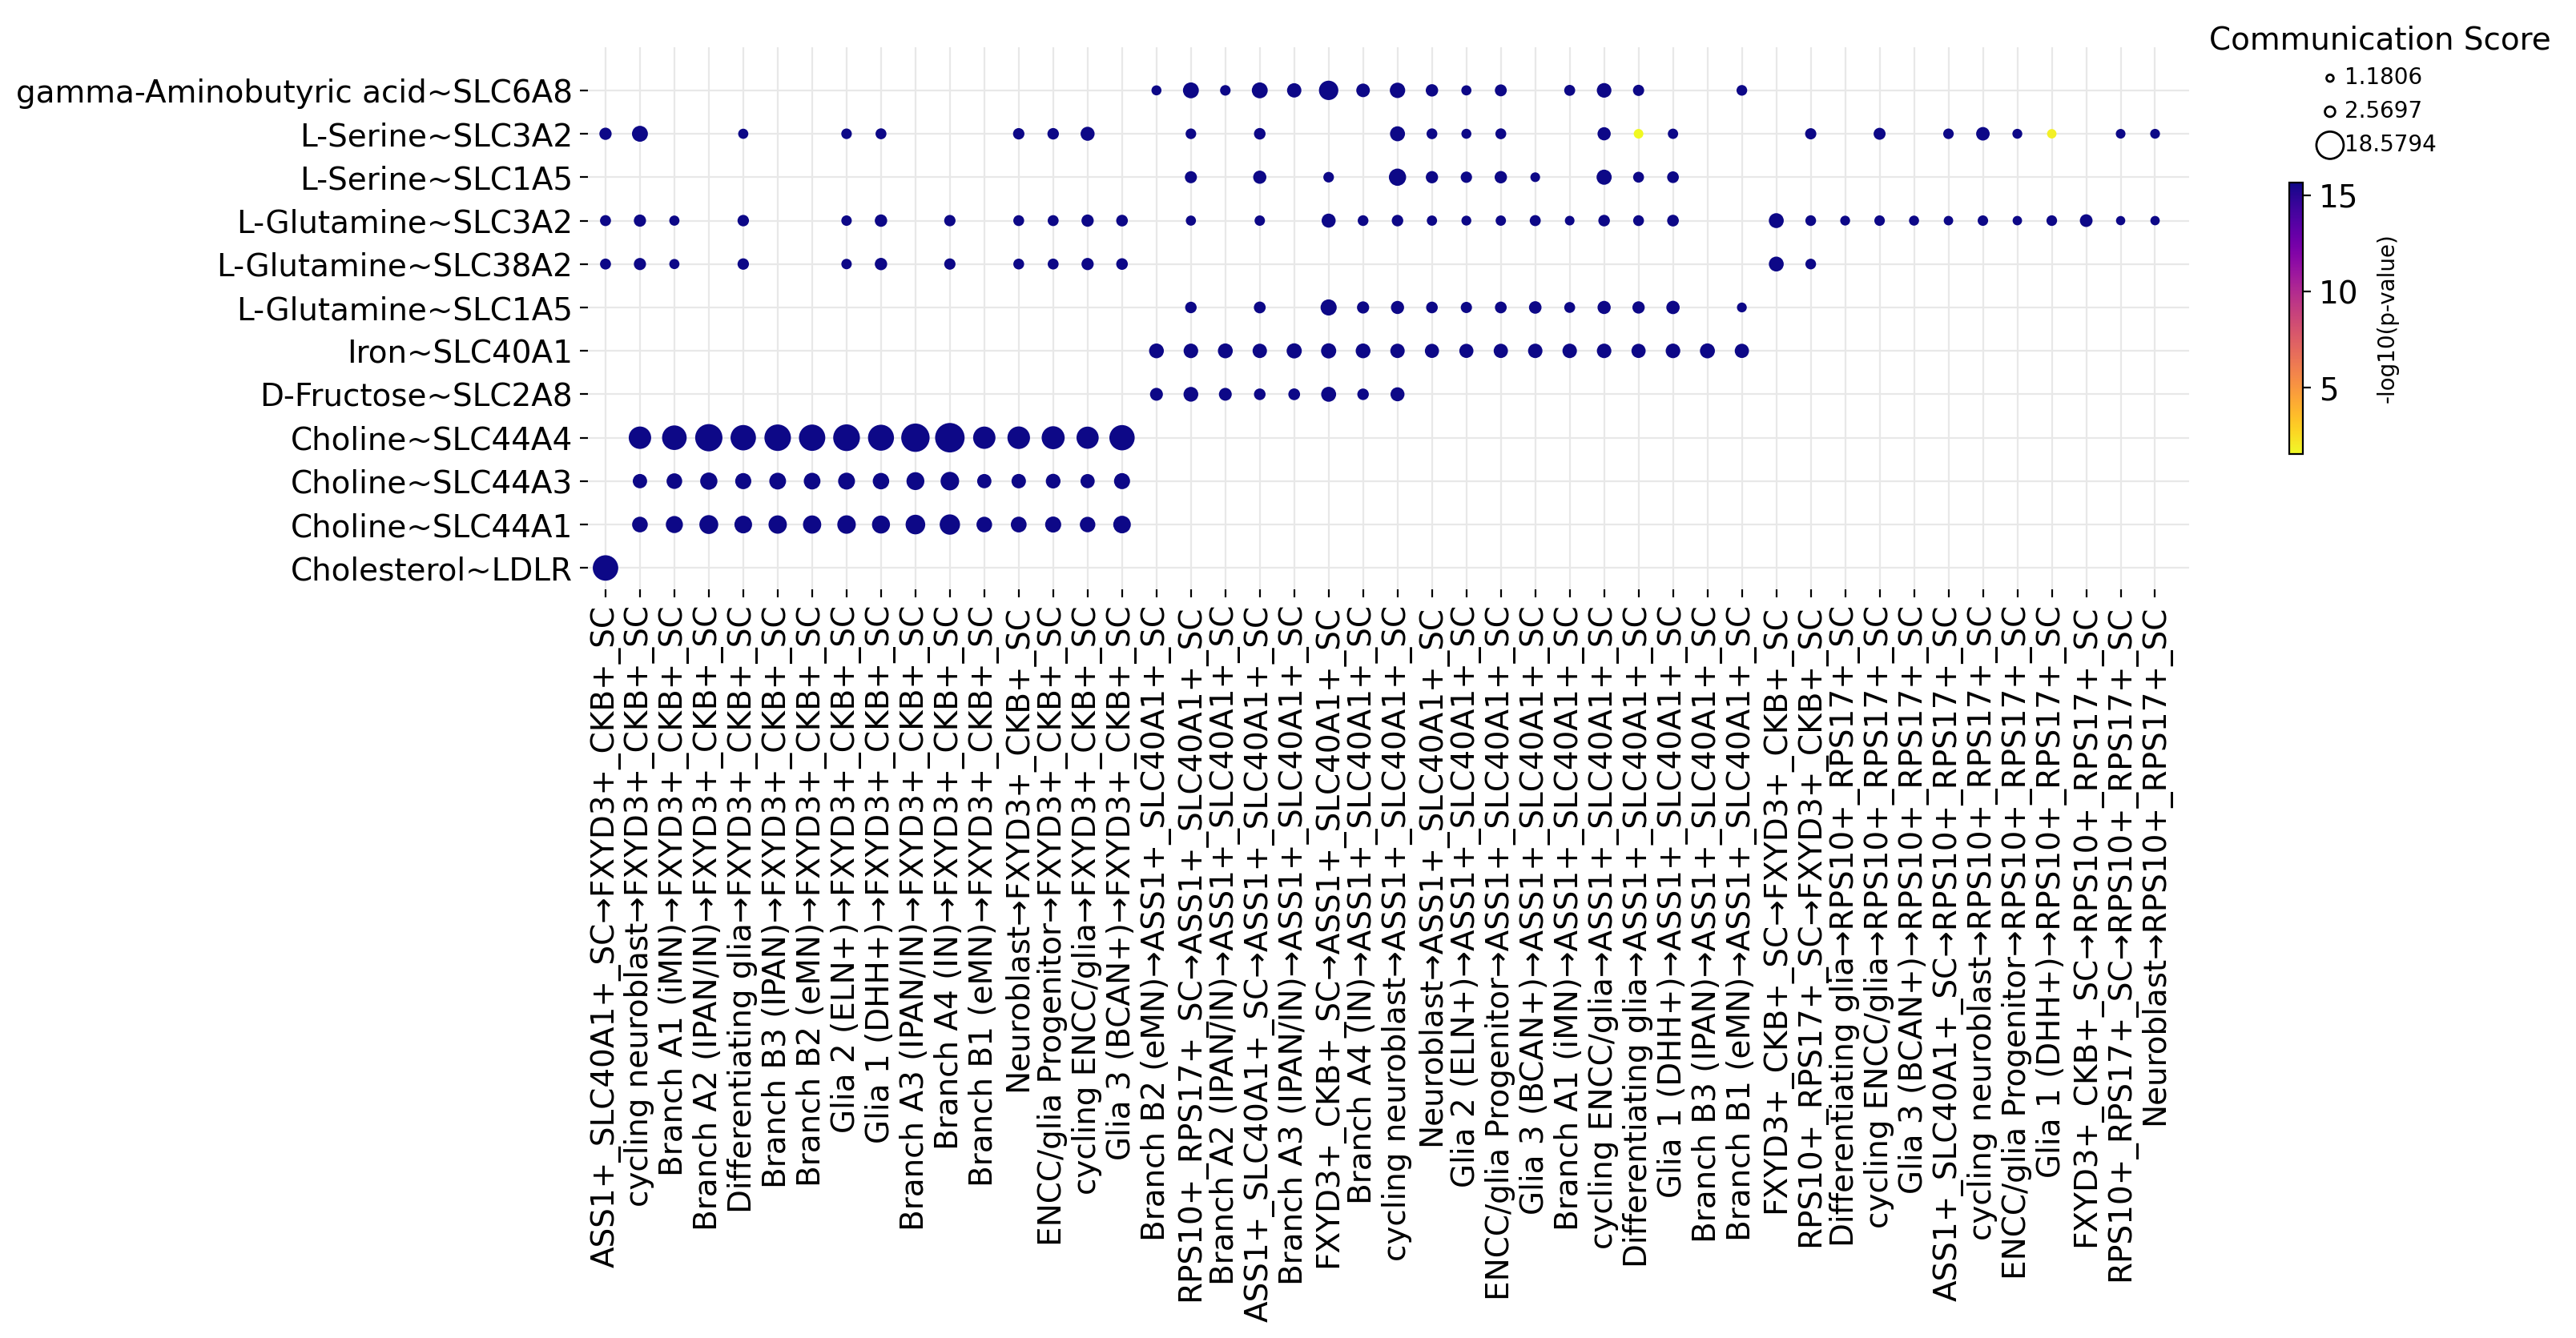

In [54]:
mebo_obj.commu_dotmap(
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                and_or = 'and',
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                figsize = 'auto',
                cmap = 'plasma_r',
                node_size_norm = (10, 150),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                swap_axis = False,
                return_fig = False
                )

[November 20, 2023 16:05:24]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


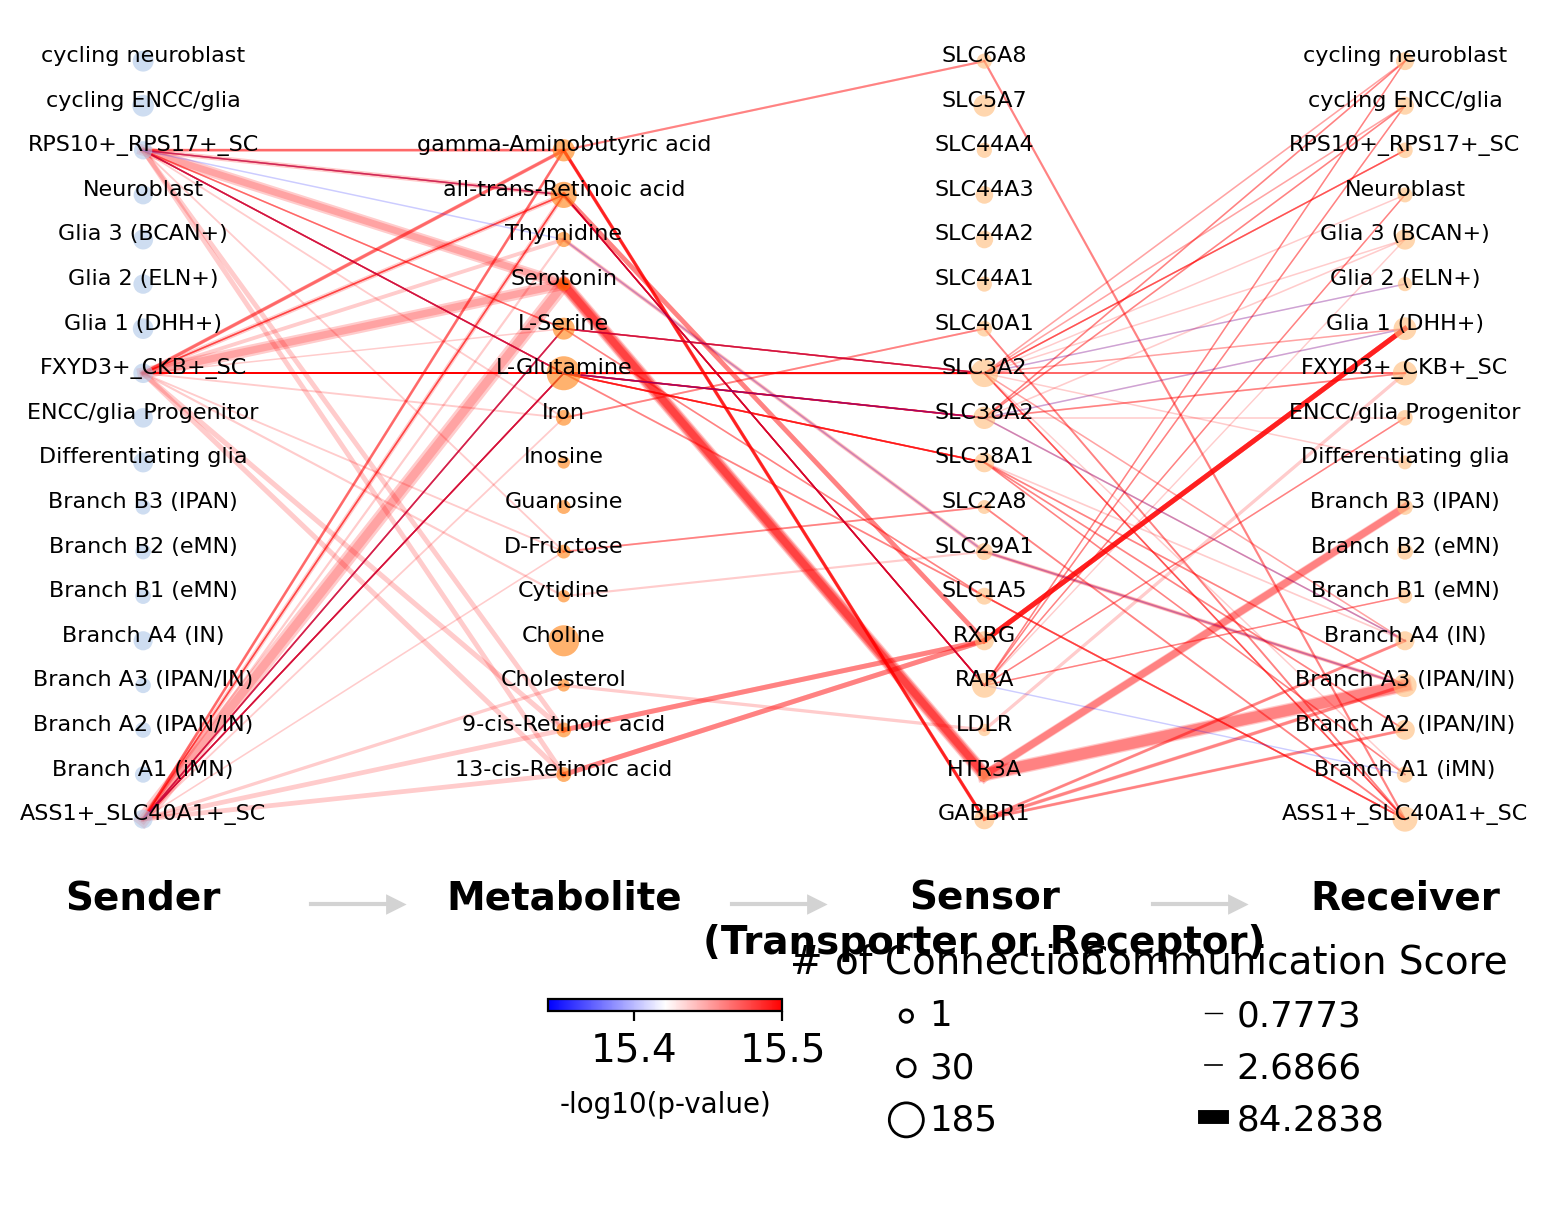

In [55]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = [],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[November 20, 2023 16:05:24]: plot flow plot to show the communications from Sender -> Metabolite -> Sensor -> Receiver


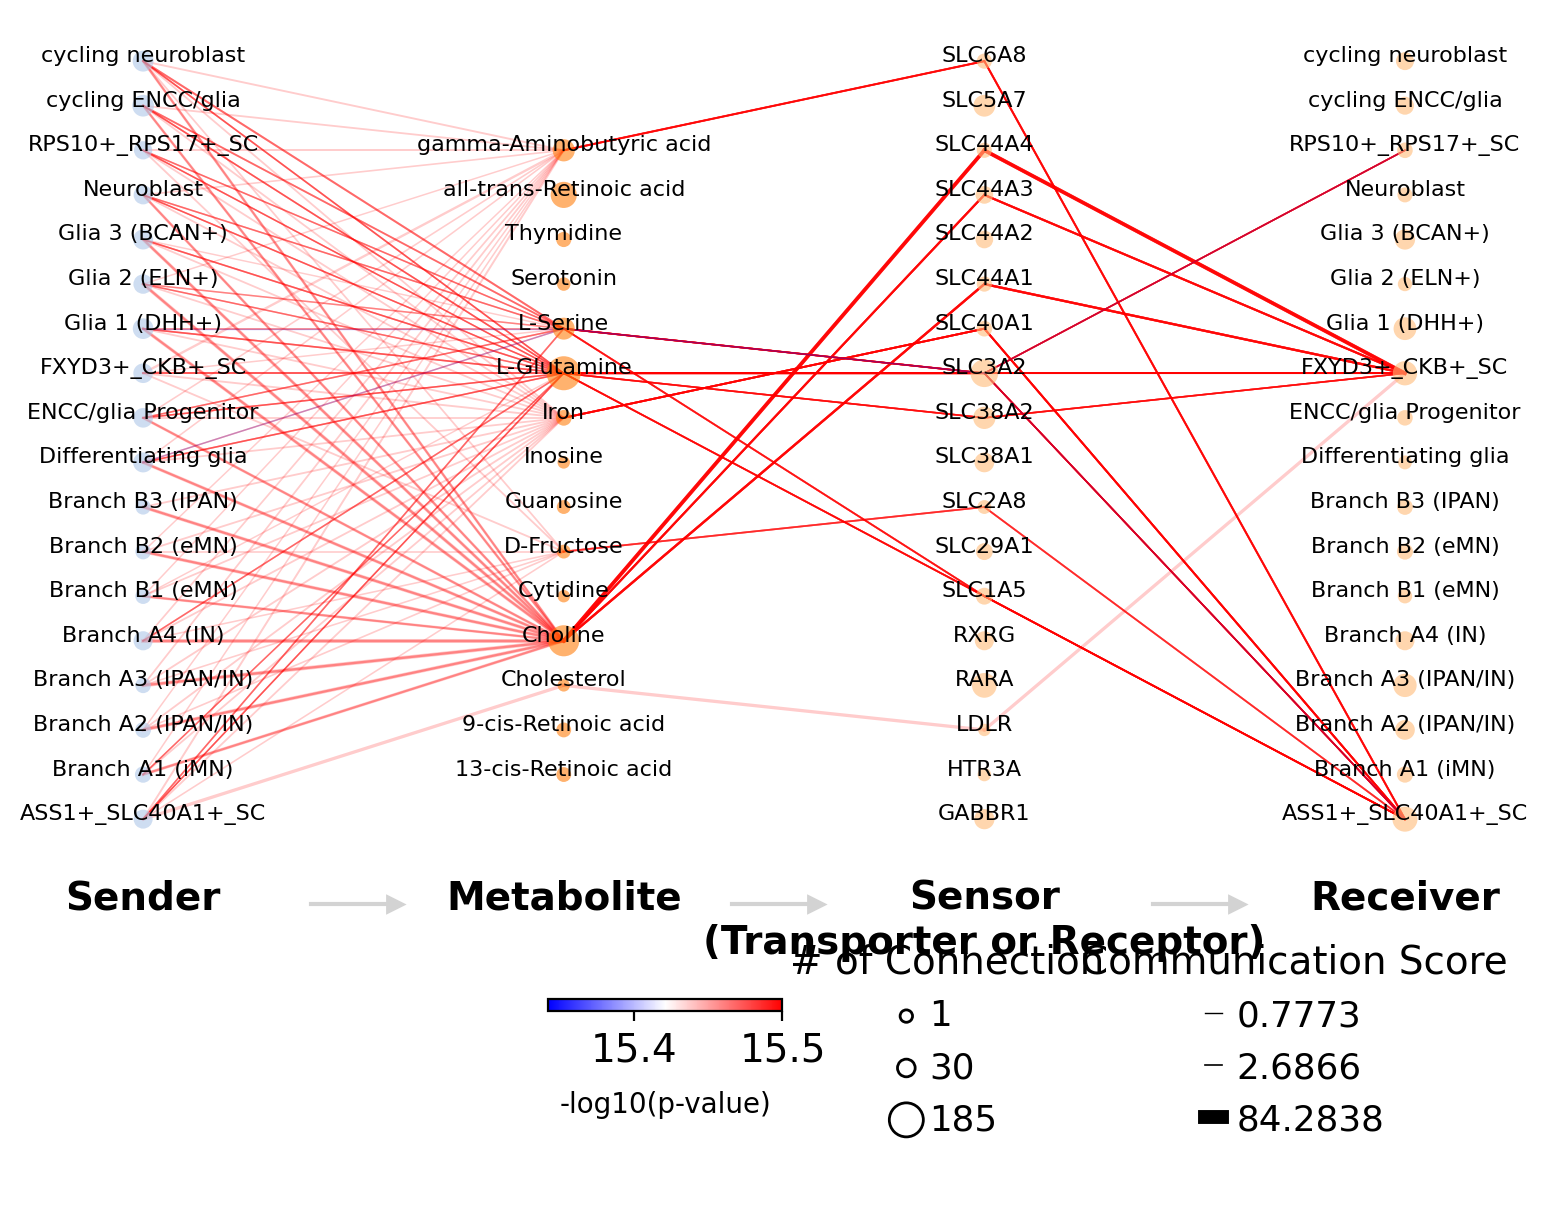

In [56]:
mebo_obj.FlowPlot(
                pval_method = 'permutation_test_fdr',
                pval_cutoff = 0.05,
                sender_focus = [],
                metabolite_focus = [],
                sensor_focus = [],
                receiver_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                remove_unrelevant = False,
                and_or = 'and',
                node_label_size = 8,
                node_alpha = 0.6,
                figsize = 'auto',
                node_cmap = 'tab20',
                line_cmap = 'bwr',
                line_vmin = None,
                line_vmax = 15.5,
                node_size_norm = (20, 150),
                linewidth_norm = (0.5, 5),
                save = None,
                show_plot = True,
                comm_score_col = 'Commu_Score',
                comm_score_cutoff = 0,
                text_outline = False,
                return_fig = False
            )

[November 20, 2023 16:05:25]: Warnings: no sensors to plot
[November 20, 2023 16:05:25]: Find metabolites ['Iron', 'Serotonin', 'Guanosine', 'Inosine', 'Cholesterol', 'L-Glutamine', 'Cytidine', 'L-Serine', 'Thymidine', '9-cis-Retinoic acid', 'all-trans-Retinoic acid', 'gamma-Aminobutyric acid', 'Choline', '13-cis-Retinoic acid', 'D-Fructose'] to plot violin


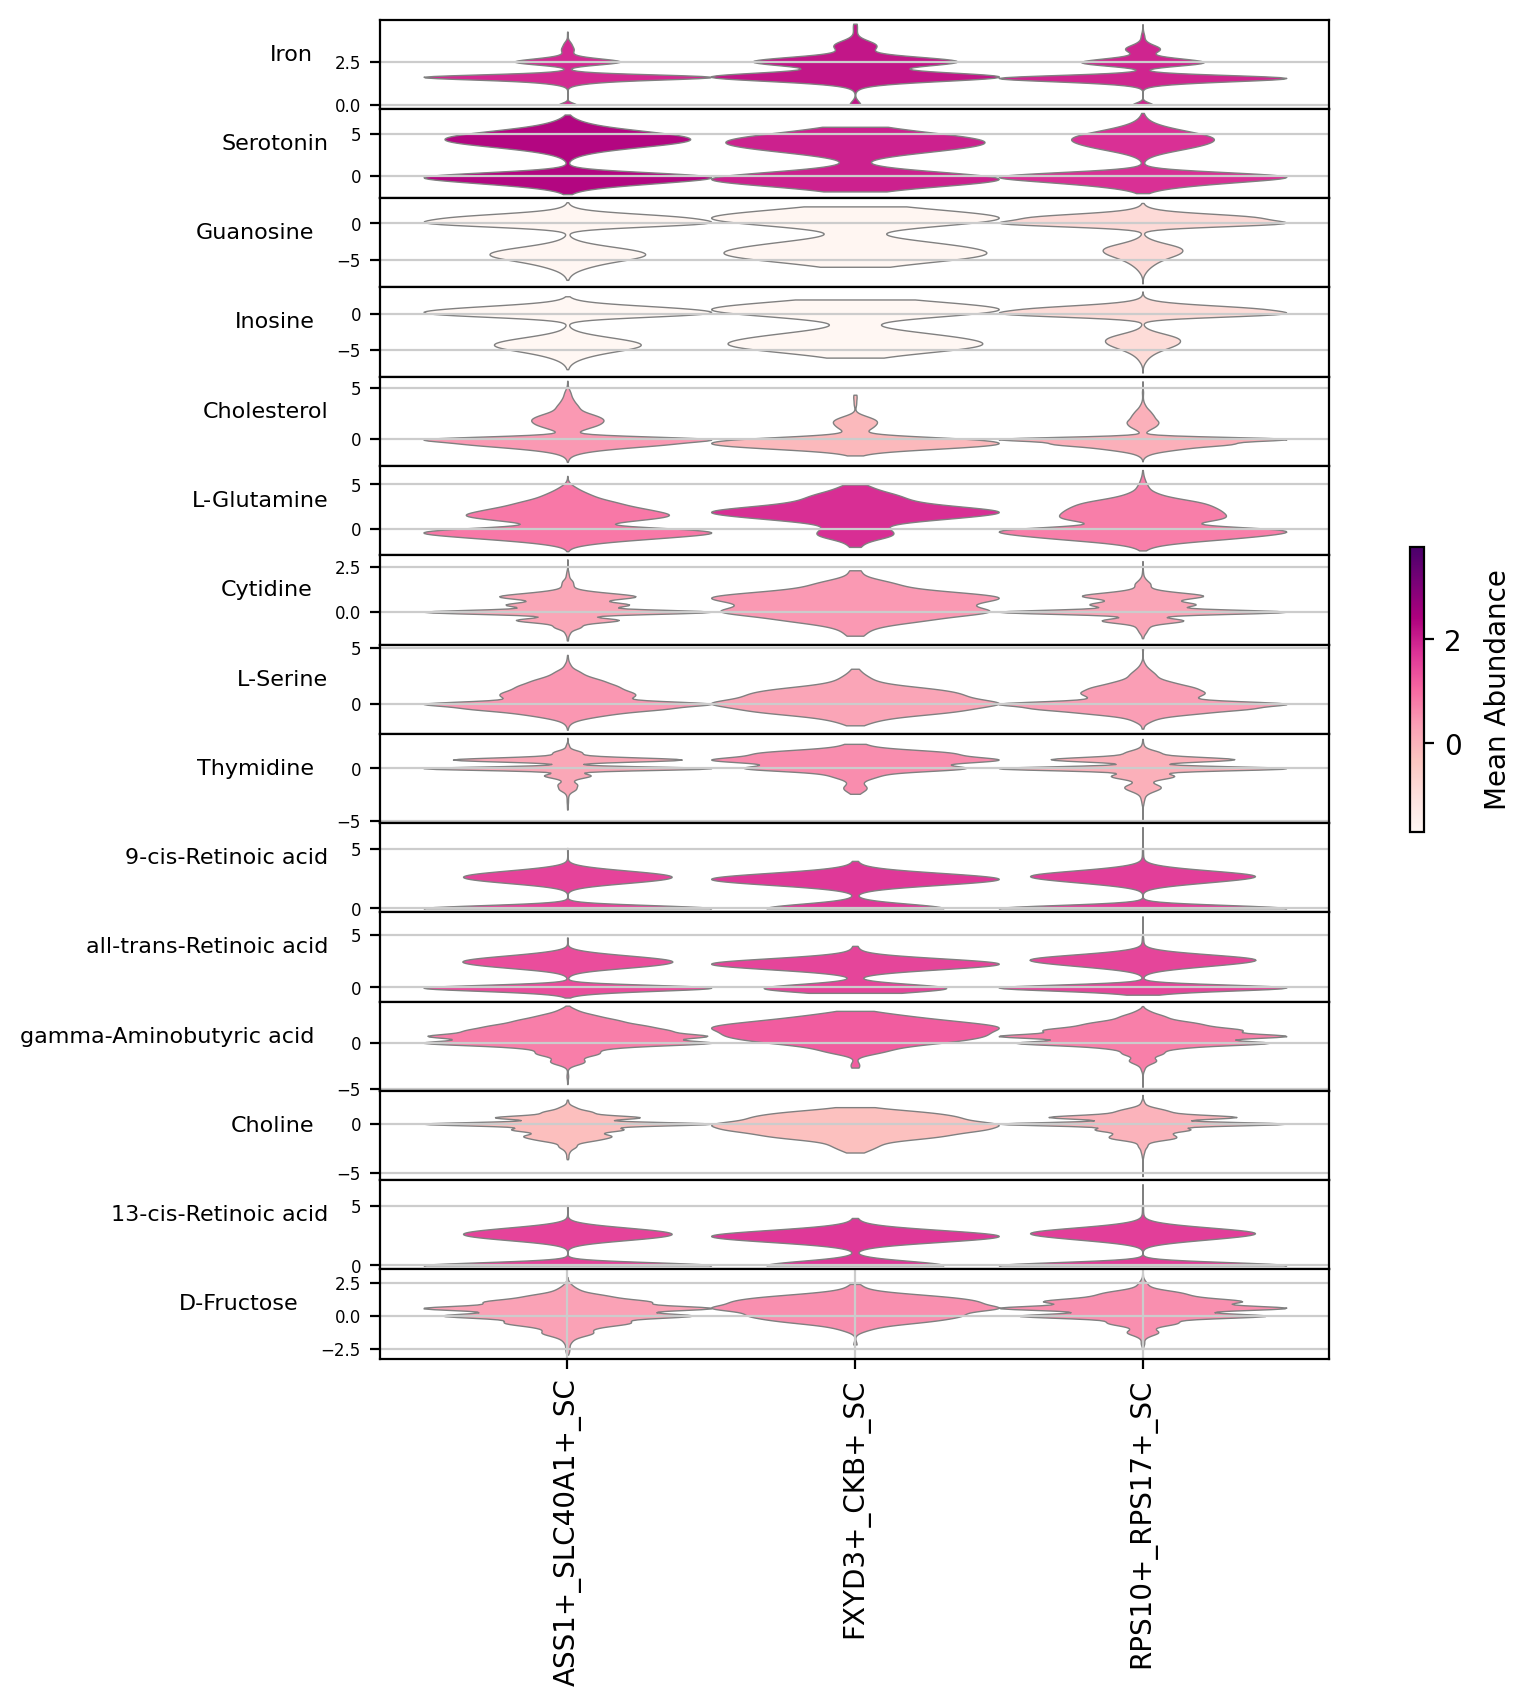

In [57]:
commu_df = mebo_obj.commu_res.copy()
commu_df = mebo_obj.commu_res.copy()
good_met = commu_df[(commu_df['permutation_test_fdr']<=0.05)]['Metabolite_Name'].sort_values().unique()

mebo_obj.violin_plot(
                    sensor_or_met = good_met[:15], ## only top 5 as example
                    cell_focus = ['ASS1+_SLC40A1+_SC', 'RPS10+_RPS17+_SC', 'FXYD3+_CKB+_SC'],
                    cmap = 'RdPu',
                    vmin = None,
                    vmax = None,
                    figsize = 'auto',
                    cbar_title = '',
                    save = None,
                    show_plot = True
                    )